<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/DAT264x_Identifying_Appliances_from_Energy_Use_Spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
root = os.getcwd()
print(root)
print(os.listdir())

/workspace/notebooks/nfs/DAT264
['train_labels.csv', 'unzip.ipynb', 'test', 'train', 'submission_format.csv', 'submit_1.csv', 'DAT264x_Identifying_Appliances_from_Energy_Use_Spectrograms.ipynb', '.ipynb_checkpoints']


In [0]:
import numpy as np
import warnings;warnings.simplefilter('ignore')
from numpy import array
import keras
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from tqdm import tqdm_notebook as tqdm
import os
import seaborn as sns
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
from keras import regularizers

Using TensorFlow backend.


# Load train

In [0]:
train_images = []
train_idxs = []
train_labels = []
train_data_path = root + '/' +'train'

#img
for file_name in tqdm(os.listdir(train_data_path)):
  train_images.append(image.load_img(train_data_path+'/'+file_name))
  train_idxs.append(file_name.split('_')[0])

train = pd.DataFrame(index=train_idxs)
train.index.name = 'id'
train.index = train.index.astype('int64')
train['img'] = train_images

#labels
labels_path = root + '/' + 'train_labels.csv'
train_labels = pd.read_csv(labels_path,index_col=0)

#merge
train = train.join(train_labels)

#handle
img_1s = train[::2] # 0 ~ end step 2
img_2s = train[1::2]# 1 ~ end step 2 
train = img_1s
train['img2'] = img_2s['img']
train = train[['img','img2','appliance']]
print(train.shape)
train.head()


(576, 3)


,img,img2,appliance
id,,,
1000,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,4
1001,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,9
1002,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,4
1003,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,9
1004,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...,6


# Load test

In [0]:
test_images = []
test_idxs = []
test_data_path = root + '/' +'test'

for file_name in tqdm(os.listdir(test_data_path)):
  test_images.append(image.load_img(test_data_path + '/' + file_name))
  test_idxs.append(file_name.split('_')[0])

test = pd.DataFrame(index=test_idxs)
test.index.name = 'id'
test.index = test.index.astype('int64')
test['img'] = test_images
test = test.sort_index()

#handle
img_1s = test[::2] # 0 ~ end step 2
img_2s = test[1::2]# 1 ~ end step 2 
test = img_1s
test['img2'] = img_2s['img']
test = test[['img','img2']]
print(test.shape)
test.head()


(384, 2)


,img,img2
id,,
1576,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1577,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1578,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1579,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...
1580,<PIL.Image.Image image mode=RGB size=176x128 a...,<PIL.Image.Image image mode=RGB size=176x128 a...


# prepare data

In [0]:
X_train = train[['img','img2']]
X_test = test[['img','img2']]
Y_train = train["appliance"]

# count class

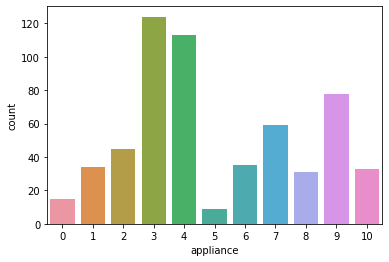

In [0]:
sns.countplot(Y_train)

# to numpy

In [0]:
def to_numpy(df):
    X = np.array([img_to_array(img).reshape((1,) + (128,176,3)) for img in df])
    X = X.astype('float32').reshape(-1, 128, 176, 3)/255.0
    return X

In [0]:
train_X1 = to_numpy(train['img'])
train_X2 = to_numpy(train['img2'])
test_X1 = to_numpy(test['img'])
test_X2 = to_numpy(test['img2'])

In [0]:
X_train = (train_X1 + train_X2) / 2
X_test = (test_X1 + test_X2) / 2
Y_train = np_utils.to_categorical(Y_train,num_classes = 11)
print('X_train.shape',X_train.shape)
print('X_test.shape',X_test.shape)
print('Y_train.shape',Y_train.shape)

X_train.shape (576, 128, 176, 3)
X_test.shape (384, 128, 176, 3)
Y_train.shape (576, 11)


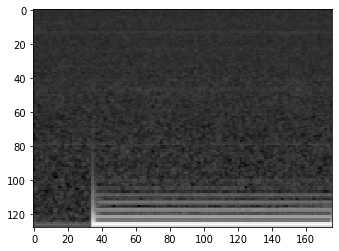

In [0]:
plt.imshow(train_X1[0])

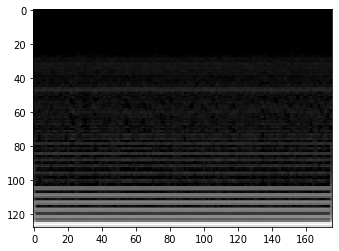

In [0]:
plt.imshow(train_X2[0])

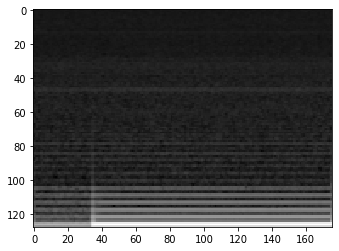

In [0]:
plt.imshow(X_train[0])

# split

In [0]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train,test_size=0.2,random_state = 42)
print('X_train.shape',X_train.shape)
print('Y_train.shape',Y_train.shape)
print('X_valid.shape',X_valid.shape)
print('Y_valid.shape',Y_valid.shape)

X_train.shape (460, 128, 176, 3)
Y_train.shape (460, 11)
X_valid.shape (116, 128, 176, 3)
Y_valid.shape (116, 11)


In [0]:
model = Sequential()
#conv 1
model.add(Conv2D(7,(7,7),padding='same',activation='relu',input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(3,3)))
#conv 2
model.add(Conv2D(5,(5,5),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))
#Flatten
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(11, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 176, 7)       1036      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 58, 7)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 58, 5)         880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 19, 5)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1330)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1330)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               170368    
__________

In [0]:
model.compile(optimizer = Adam(lr=0.001), 
              loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

In [0]:
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0, 
                   patience = 20,  
                   mode = 'min')

In [0]:
history = model.fit(X_train,Y_train,
                    batch_size = len(X_train),
                    epochs = 1000,
                    validation_data = (X_valid,Y_valid),
                    verbose = 1,
                    callbacks = [es])

Train on 460 samples, validate on 116 samples
Epoch 1/1000
460/460 [==============================] - 4s 10ms/step - loss: 2.4798 - acc: 0.0957 - val_loss: 2.3900 - val_acc: 0.0431
Epoch 2/1000
460/460 [==============================] - 0s 252us/step - loss: 2.3857 - acc: 0.1109 - val_loss: 2.3036 - val_acc: 0.0690
Epoch 3/1000
460/460 [==============================] - 0s 265us/step - loss: 2.3088 - acc: 0.1435 - val_loss: 2.2290 - val_acc: 0.2672
Epoch 4/1000
460/460 [==============================] - 0s 254us/step - loss: 2.2660 - acc: 0.1804 - val_loss: 2.1584 - val_acc: 0.2672
Epoch 5/1000
460/460 [==============================] - 0s 256us/step - loss: 2.2054 - acc: 0.2239 - val_loss: 2.1003 - val_acc: 0.2672
Epoch 6/1000
460/460 [==============================] - 0s 249us/step - loss: 2.1690 - acc: 0.2239 - val_loss: 2.0596 - val_acc: 0.2845
Epoch 7/1000
460/460 [==============================] - 0s 254us/step - loss: 2.1334 - acc: 0.2652 - val_loss: 2.0316 - val_acc: 0.3966
Epo

# history

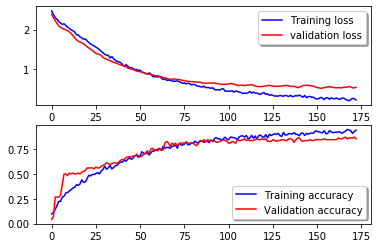

In [0]:
fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# confusion_mtx

In [0]:
Y_pred = model.predict(X_valid)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_valid,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
pd.DataFrame(confusion_mtx).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9,10
0,4,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,1,0,0,0,0,1,0
2,1,0,5,0,0,0,1,0,0,0,0
3,0,0,0,28,1,0,0,0,1,1,0
4,0,0,0,0,23,0,0,0,0,3,0
5,0,0,0,0,0,3,0,0,0,0,0
6,0,0,0,0,0,0,5,0,0,1,0
7,0,0,0,0,0,0,0,5,0,0,0
8,0,0,0,0,0,0,0,1,7,0,0
9,0,0,0,0,0,0,0,1,0,14,0


# Display some error results 

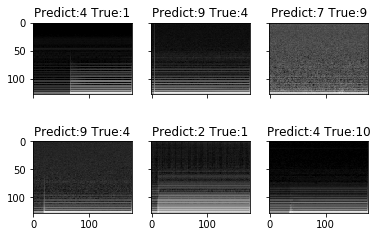

In [0]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape(X_train.shape[1:]))
            ax[row,col].set_title("Predict:{} True:{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [0]:
submit = pd.DataFrame()
submit['id'] = test.index
submit['appliance'] = [np.argmax(i) for i in model.predict(X_test)]
submit.head()

,id,appliance
0,1576,9
1,1577,5
2,1578,4
3,1579,2
4,1580,8


In [0]:
submit.to_csv('submit_1.csv',index=False)